# Minimize Free Energy

Here we explore the states which minimize the free energy,
$$ E = <H> - T S = \text{Tr}(\rho H) + T \text{Tr}(\rho \ln \rho)$$

In [1]:
from Define_Paulis import I, X, Y, Z, Mdot, bkt
import numpy as np
import scipy.linalg as ln

## Directly minimize the density matrix

Let us start by taking $\rho$ to be diagonal in the eigenbasis of H.
\begin{equation}
\rho = \begin{pmatrix} e^{x_1} & 0 & 0 & 0 \\ 0 & e^{x_2} & 0 & 0 \\ 0 & 0 & e^{x_3} & 0 \\ 0 & 0 & 0 &  \ddots  \end{pmatrix}
\end{equation}
so that $$ \text{Tr}(\rho H) = e^{x_1} E_0 + e^{x_2} E_1 + e^{x_3} E_2 + \ldots$$
and 
$$ \text{Tr}(\rho \ln \rho) = e^{x_1} x_1 + e^{x_1} x_2 + e^{x_1} x_3 + \ldots $$

We search for minima for each parameter, 
$$ 0 = \frac{d}{dx_n}F = e^{x_n}E_0 + T(x_n+1)e^{x_n} $$
$$ x_n = -\frac{E_n}{T} - 1$$
Since we have neglected normalization the $-1$ is meaningless.  

Let's check this,


In [2]:
H = Z(0,2) + Z(1,2) + 0.3*Mdot([X(0,2),X(1,2)])

e,y = ln.eig(H)
arg = np.argsort(e)
psi = np.conjugate(np.transpose(y))
    


def ketbra(psia,psib):
    out = [[0 for i in range(len(psia))] for j in range(len(psib))]
    for i in range(len(psia)):
        for j in range(len(psib)):
            out[i][j] = psia[i]*np.conjugate( psib[j] )
    return np.array(out)
            
def S(rho):
    e,y = ln.eig(rho)
    s = sum([np.round( (e[n]+10**-28)*np.log(e[n]+10**(-28)) , 8) for n in range(len(e))])
    return s

def FreeE(T,H,rho):
    #print('H: ',np.trace(Mdot([H,rho])))
    #print('S: ', + T*S(rho))
    return np.trace(Mdot([H,rho])) + T*S(rho)
    

def rho(a,b,c,d):
    rho0 = a*ketbra(psi[arg[0]],psi[arg[0]]) + b*ketbra(psi[arg[1]],psi[arg[1]]) + c*ketbra(psi[arg[2]],psi[arg[2]]) + d*ketbra(psi[arg[3]],psi[arg[3]])
    rho0 = rho0/np.trace(rho0)
    return rho0


In [3]:
T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rho0 = rho(a,b,c,d)

FreeE(T,H,rho0)



(-3.2722345306848+0j)

In [4]:
FEl = []
drl = []
T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
for dri in range(0,90):
    dr = dri*0.1 - a
    rho0 = rho(abs(a+dr),abs(b),abs(c),abs(d))
    FE = FreeE(T,H,rho0)
    FEl.append(FE)
    drl.append(dr)

/opt/miniconda3/envs/qiskit_3.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


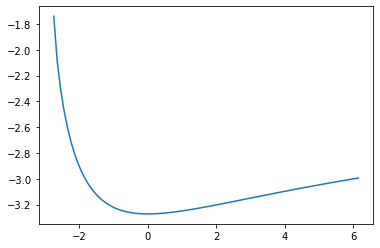

In [5]:
import matplotlib.pyplot as plt

plt.plot(drl,FEl)


This seems to be the correct minimum. 

## Starting from entropy

Now let us start in the entropic state,
\begin{equation}
\rho_0 = e^{-E_0/T}|00><00| + e^{-E_1/T}|10><10| + e^{-E_2/T}|01><01| + e^{-E_3/T}|11><11| + 
\end{equation}
then we apply a basis rotation $U$ so that $$ U^{\dagger}\rho U = e^{-E_0/T}|E_0><E_0| + e^{-E_1/T}|E_1><E_1| + e^{-E_2/T}|E_2><E_2| + e^{-E_3/T}|E_3><E_3| $$


In [6]:


def rho0(a,b,c,d):
    rho = [[0 for i in range(4)] for j in range(4)]
    rho[arg[0]][arg[0]] = a
    rho[arg[1]][arg[1]] = b
    rho[arg[2]][arg[2]] = c
    rho[arg[3]][arg[3]] = d
    rho = rho/np.trace(rho)
    return rho


T=2.0
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )

rhop = Mdot([np.conjugate(np.transpose(psi)),rho0(a,b,c,d),psi])


print("Entropt is the same: ", S(rho0(a,b,c,d)) - S(rho(a,b,c,d)))

print("density matrix after rotation: ",np.amax(np.abs( rhop - rho(a,b,c,d) )) )


Entropt is the same:  0j
density matrix after rotation:  2.7755575615628914e-17


## Generate entropy from measurments

Starting with the quantum system in the state 
$$ \rho_i = |00> <00| $$ 
we perform a unitary operation to take the state to 
$$ \rho_v = V^{\dagger}\rho V = (e^{-E_0/2T}|00> + e^{-E_1/2T}|10> + e^{-E_2/2T} |01> + e^{-E_3/2T}|11>)(e^{-E_0/2T}<00| + e^{-E_1/2T}<10| + e^{-E_2/2T} <01| + e^{-E_3/2T}<11|)$$ 
we then measure the system 
$$ \rho_0 = \sum_s |s><s|\rho_v|s><s| = e^{-E_0/T} |00><00| + e^{-E_1/T} |10><10| + e^{-E_2/T} |01><01| + |e^{-E_3/T} |11><11|  $$
Then we perform a unitary rotation to get it in the eigenbasis
$$ \rho =  U^{\dagger}\rho U = e^{-E_0/T} |E_0><E_0| + e^{-E_1/T}|E_1><E_1| + e^{-E_2/T} |E_2><E_2| + e^{-E_3/T} |E_3><E_3|$$

In [7]:
def M(il,N):
    Ml = [I(N)]
    for i in il:  
        M2 = []
        for M in Ml:
            Ma = 1/2*Mdot([M,(I(N)+Z(i,N))])
            Mb = 1/2*Mdot([M,(I(N)-Z(i,N))])
            M2.append(Ma)
            M2.append(Mb)
        Ml = M2
    return Ml

def Meas(rho,il):
    N = int(np.log2(len(rho)))
    ml = M(il,N)
    rho_new = 0*rho
    for m in ml:
        rho_new = rho_new + Mdot([m,rho,m])
    return rho_new

In [8]:
N = np.sqrt(a + b + c + d)
a2 = np.sqrt(a)/N
b2 = np.sqrt(b)/N
c2 = np.sqrt(c)/N
d2 = np.sqrt(d)/N

# This only works because of symmetry in the eigenvalues
V0 = np.array([a2,b2,c2,d2])
V1 = np.array([b2,-a2,0,0])/np.sqrt(b2**2+a2**2)
V2 = np.array([0,0,d2,-c2])/np.sqrt(d2**2+c2**2)
V3 = np.array([-c2,-d2,a2,b2])

V0 = np.array([d2,a2,c2,b2])
V1 = np.array([a2,-d2,0,0])/np.sqrt(d2**2+a2**2)
V2 = np.array([0,0,b2,-c2])/np.sqrt(b2**2+c2**2)
V3 = np.array([-c2,-b2,d2,a2])

V = [V3,V0,V2,V1]
Vd = np.conjugate(np.transpose(V))


Mdot([Vd,V])

Mdot([Vd,[1,0,0,0]])


rhoi = rho0(1,0,0,0)
rhov = Mdot([Vd,rhoi,V])
rho00 = Meas(rhov,[0,1,2,3])
rhop = Mdot([np.conjugate(np.transpose(psi)),rho00,psi])

print("Entropt after measurment: ", S(rho00) - S(rho(a,b,c,d)))
print("Final density matrix: ",np.amax(np.abs( rhop - rho(a,b,c,d) )) )

Entropt after measurment:  0j
Final density matrix:  2.7755575615628914e-17


# Varriational U and V

What we would really like is for both $V$ and $U$ to be unknown.  We then find both $V$ and $U$ variationally.  I suspect that as long as you get the same enetropy when measuring that state after applying $V$, the specific from of $V$ is not important.  We will define $V$ with only a single variational parameter $V(S)$ which corresponds to the amount of entropy that will be generated.  
$$ V = \prod_{i=0}^j \hat{H}_i\hat{R}_{Hj}(\phi)$$
such that 
$$S = j \ln 2 + \cos(\phi/2)^2 \ln{\cos(\phi/2)^2} + \sin(\phi/2)^2 \ln{\sin(\phi/2)^2}$$
where $\hat{H}_i$ is a Hadamard gate on qubit $i$ and 
$$ \hat{R}_{Hj}(\phi) = Z_j(\cos(\phi/2)I - i\sin(\phi/2)Y_j) $$

In [23]:
import scipy.optimize as op

def Hd(i,N):
    return 1/np.sqrt(2)*(Z(i,N) + X(i,N))

def RH(theta,i,N):
    return Mdot([Z(i,N),np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)])


def f(x,S):
    dx = 10**(-15)
    return np.cos(x/2)**2 * np.log(np.cos(x/2)**2 + dx) + np.sin(x/2)**2 * np.log(np.sin(x/2)**2 + dx) - S

def V(S,N):
    j = int(-S/np.log(2))
    if j >= N:
        raise NameError("An entropy of "+str(S)+" requires at least "+str(j+1)+" qubits.")
    dS = S + j*np.log(2)
    phi = op.brentq(f,0,np.pi/2, args = (dS))
    vout = I(N)
    for i in range(j):
        vout = Mdot([Hd(i,N),vout])
    vout = Mdot([RH(phi,j,N),vout])
    return vout



In [10]:
N=2
Sin = -1.312698
rhoi = rho0(1,0,0,0)
rhov = Mdot([np.conjugate(np.transpose(V(Sin,N))),rhoi,V(Sin,N)])
rho00 = Meas(rhov,[0,1,2,3])

S(rho00)

(-1.312698+0j)

For $U$ we will try the Hardware efficient ansatz.  

In [11]:
def Ry(theta,i,N):
    return np.cos(theta/2)*I(N) - 1j*np.sin(theta/2)*Y(i,N)

def Cx(i,j,N):
    return 1/2*( I(N) + Z(i,N) + X(j,N) - Mdot([Z(i,N),X(j,N)]) )


def U(Phi):
    T = len(Phi)
    N = len(Phi[0])
    uout = I(N)
    for t in range(T):
        for i in range(N):
            phi = Phi[t][i]
            uout = Mdot([Ry(phi,i,N),uout])
        for i in range(0,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
        for i in range(1,N,2):
            uout = Mdot([Cx(i,i+1,N),uout])
    return uout

In [12]:
N=2
Sin = -(0.999)*2*np.log(2)
Phi = [[0.3,0.2],[0.5,0.1],[0.3,0.7]]

def rhof(Sin,Phi):
    N = len(Phi[0])
    rhoi = rho0(1,0,0,0)
    rhov = Mdot([np.conjugate(np.transpose(V(Sin,N))),rhoi,V(Sin,N)])
    rho00 = Meas(rhov,[0,1,2,3])
    rhop = Mdot([np.conjugate(np.transpose(U(Phi))),rho00,U(Phi)])
    return rhop

rhop = rhof(Sin,Phi)

FreeE(0.0,H,rhop)

(0.017612836732944837+0j)

In [13]:
def enforce_bounds(S,Smin,Smax):
    if S < Smin:
        S = Smin
    if S > Smax:
        S = Smax
    return S

# Minimize

In [17]:

def SPSA(T,S0,phi0,k_max):
    beta = 0.201
    A = 10
    a = 0.05
    gamma = 0.101
    c = 0.4
    np.random.seed(10)
    
    #Initalization
    k = 0
    Nt = len(phi0)
    N = len(phi0[0])
    min_S = -0.999*N*np.log(2)
    phi_k = np.array(phi0)
    S_k = S0
    E_l = []
    k_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for t in range(Nt):
            for q in range(N):
                Delta_k[t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta S
        Delta_Sk =  1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        S_k_A = S_k + c_k*Delta_Sk
        S_k_B = S_k - c_k*Delta_Sk
        S_k_A = enforce_bounds(S_k_A, min_S, 0)
        S_k_B = enforce_bounds(S_k_B, min_S, 0)
        
        #Find rho 
        rho_A = rhof(S_k_A,phi_k_A)
        rho_B = rhof(S_k_B,phi_k_B)
            
        #Find Free Energy    
        E_A = FreeE(T,H,rho_A)
        E_B = FreeE(T,H,rho_B)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_Sk = g * Delta_Sk
        S_k = S_k - a_k * g_Sk
        S_k = enforce_bounds(S_k, min_S, 0)
        
        #Find new rho
        rho = rhof(S_k,phi_k)
        
        #Find new Free Energy
        E = FreeE(T,H,rho)
        
        print(k,S_k,E)
        E_l.append(E)
        k_l.append(k)

    return E_l,k_l,S_k,phi_k

In [18]:
S0 = -(0.0)*2*np.log(2)
phi0 = [[0.3,0.2],[0.5,0.1],[0.3,0.7],[1.2,0.9]]
#phi0 = [[0.3,0.2],[-0.5,0.1],[0.3,0.7],[0.1,0.8],[0.3,0.2],[0.3,0.3],[-0.2,0.1]]

T = 2.0
El,kl,Sf,phif = SPSA(T, S0, phi0, 300)

0 -0.04483333204362049 (-1.5189237922029206+0j)
1 -0.13940325319353297 (-1.9856701295357568+0j)
2 -0.1877932492032124 (-2.0169026406942807+0j)
3 -0.2070785134106998 (-2.0266928600553733+0j)
4 -0.2261813301290304 (-2.0224196832617536+0j)
5 -0.3010735533155451 (-2.2736474380065568+0j)
6 -0.3303185046371814 (-2.254454238875483+0j)
7 -0.40722982307536437 (-2.208747464211512+0j)
8 -0.4709177603474114 (-2.246182803373226+0j)
9 -0.4830942059826093 (-2.250444328593682+0j)
10 -0.5201804932763272 (-2.309651219829908+0j)
11 -0.5298314392573874 (-2.309455220438655+0j)
12 -0.5527904330715645 (-2.3177086327351475+0j)
13 -0.6328615883558851 (-2.1988337163028477+0j)
14 -0.6613142940913591 (-2.2018443640935503+0j)
15 -0.6992927454137793 (-2.0969827651529456+0j)
16 -0.7064894230600965 (-2.0938286423711205+0j)
17 -0.7055535217711494 (-2.092410156492125+0j)
18 -0.777698285175964 (-2.3232559966176387+0j)
19 -0.8177024781411668 (-2.3971480440104704+0j)
20 -0.8293705623872656 (-2.4184159324736454+0j)
21 -0.8

173 -1.3849080667587708 (-2.819689288169915+0j)
174 -1.3849080667587708 (-2.819682346103779+0j)
175 -1.3817785945637924 (-2.8536060744271348+0j)
176 -1.3849080667587708 (-2.8199699732233787+0j)
177 -1.3799293508797352 (-2.8673580529157463+0j)
178 -1.3787757382372825 (-2.8744175442690985+0j)
179 -1.3780847669783534 (-2.878236336979585+0j)
180 -1.3847474725105668 (-2.822491186210496+0j)
181 -1.3803513378580559 (-2.8648527021731556+0j)
182 -1.3822293301673831 (-2.850585175322592+0j)
183 -1.3832103884284541 (-2.8414417334141473+0j)
184 -1.3838053863173845 (-2.835009569239133+0j)
185 -1.3849080667587708 (-2.8201771240280453+0j)
186 -1.3849080667587708 (-2.8201619091302934+0j)
187 -1.3849080667587708 (-2.8201066650462194+0j)
188 -1.3849080667587708 (-2.820228128084411+0j)
189 -1.3793540562168896 (-2.87181840725791+0j)
190 -1.3757748762064157 (-2.8908971969727872+0j)
191 -1.3780991296272471 (-2.8792430347680575+0j)
192 -1.3849080667587708 (-2.8202471803145603+0j)
193 -1.3849080667587708 (-2.8

344 -1.3687621641928986 (-2.928484900624538+0j)
345 -1.3715324038499717 (-2.9186170322213876+0j)
346 -1.366994815499609 (-2.934658073778718+0j)
347 -1.3635529309821695 (-2.9447498564546324+0j)
348 -1.367307976317797 (-2.933446375763358+0j)
349 -1.36782282134751 (-2.9318301435866005+0j)
350 -1.3707641132744366 (-2.921502169577646+0j)
351 -1.3668044359228588 (-2.935360674962001+0j)
352 -1.3627236543793548 (-2.947583428086758+0j)
353 -1.3642565984171882 (-2.9434001549554285+0j)
354 -1.3603500358502874 (-2.953902647910012+0j)
355 -1.3550742947246612 (-2.9667382012287375+0j)
356 -1.355131017667624 (-2.966628509832676+0j)
357 -1.3514655051191136 (-2.9736753048601052+0j)
358 -1.3486562361858325 (-2.9787133582026657+0j)
359 -1.3512077855107347 (-2.9742680715569523+0j)
360 -1.3504352748358532 (-2.9755149966368974+0j)
361 -1.349385093327861 (-2.977178730493501+0j)
362 -1.3480069476925944 (-2.979422236674728+0j)
363 -1.348109441155167 (-2.9792337552325736+0j)
364 -1.3477650885051426 (-2.979743604

514 -1.317906074782417 (-3.030353094515124+0j)
515 -1.3147021420510079 (-3.032921059538709+0j)
516 -1.3118953153652992 (-3.034733154715528+0j)
517 -1.3137266474390632 (-3.0333317984482053+0j)
518 -1.3177066492406893 (-3.0308363639780245+0j)
519 -1.317442652865322 (-3.0310233833128315+0j)
520 -1.3134801795840296 (-3.034062949850073+0j)
521 -1.3114903484610692 (-3.035658271347765+0j)
522 -1.3183710725335755 (-3.0307329373267766+0j)
523 -1.3140075369177326 (-3.0343504146024016+0j)
524 -1.3183681888440961 (-3.0309311406406483+0j)
525 -1.3142345811747134 (-3.0340445848041155+0j)
526 -1.3084203169027995 (-3.039471344744966+0j)
527 -1.304986827858152 (-3.0415854342163193+0j)
528 -1.3006101409884465 (-3.044060601890637+0j)
529 -1.2967394727459336 (-3.046220336368523+0j)
530 -1.2949902764769428 (-3.047191097644459+0j)
531 -1.2912974077076789 (-3.0485230998167863+0j)
532 -1.2936118102347922 (-3.047457503500212+0j)
533 -1.2935532704678692 (-3.047478740587711+0j)
534 -1.2987599419268554 (-3.044803

684 -1.2762153261940392 (-3.0683242170933545+0j)
685 -1.271836032343024 (-3.069584227553391+0j)
686 -1.2676117058533485 (-3.070268163969068+0j)
687 -1.264200254536078 (-3.0704894158817577+0j)
688 -1.2657153155098415 (-3.0703581096453094+0j)
689 -1.2651357022456096 (-3.070314857548101+0j)
690 -1.2639477170363738 (-3.07066902053679+0j)
691 -1.2612987568331882 (-3.071001675932693+0j)
692 -1.2624069912498326 (-3.070850578381224+0j)
693 -1.2583867352149167 (-3.071127681079055+0j)
694 -1.2563234997416244 (-3.0712771299691743+0j)
695 -1.257678317715911 (-3.071108258053787+0j)
696 -1.260700977538088 (-3.0698855699467114+0j)
697 -1.2576111730475985 (-3.0707801047356167+0j)
698 -1.2594155269307115 (-3.07020150979632+0j)
699 -1.2564859973925657 (-3.0709818376092297+0j)
700 -1.2543056446337946 (-3.0711477497625173+0j)
701 -1.2549632524390852 (-3.0712165906519027+0j)
702 -1.2581419302202055 (-3.0712462998306846+0j)
703 -1.2583614534009067 (-3.0712357794838234+0j)
704 -1.267777156093841 (-3.06766893

854 -1.2519319701438207 (-3.0825912256811714+0j)
855 -1.2492342637555989 (-3.0825641861854676+0j)
856 -1.2501231789917369 (-3.0826499849274507+0j)
857 -1.2519770205278755 (-3.0823730426195266+0j)
858 -1.2540994770137923 (-3.0822099613972083+0j)
859 -1.2520299728176285 (-3.082650865437952+0j)
860 -1.2481086645162534 (-3.0832607450990386+0j)
861 -1.2506434841811196 (-3.083165375592574+0j)
862 -1.2530999273691237 (-3.083320218624549+0j)
863 -1.2502701603209618 (-3.083136460274957+0j)
864 -1.2525638322639276 (-3.082952269168547+0j)
865 -1.249483871875065 (-3.0827553566731387+0j)
866 -1.2473922062007827 (-3.08277218241253+0j)
867 -1.2464685376431854 (-3.0827798069662316+0j)
868 -1.2451054002318103 (-3.082712249304607+0j)
869 -1.2418100300102954 (-3.0827076139169867+0j)
870 -1.2417877770257904 (-3.082706240665871+0j)
871 -1.2440094629641678 (-3.082647080423387+0j)
872 -1.248614790522735 (-3.082646001018642+0j)
873 -1.2490489234623774 (-3.0826109312515158+0j)
874 -1.2480033684494118 (-3.08257

1025 -1.24292227124326 (-3.0879759036530494+0j)
1026 -1.2419833619919491 (-3.0879597075215592+0j)
1027 -1.243803455202873 (-3.087924632190344+0j)
1028 -1.2422773149059785 (-3.087873670108613+0j)
1029 -1.2387399122447438 (-3.0878320626242566+0j)
1030 -1.2386131562060554 (-3.0878173509253015+0j)
1031 -1.2366912297631059 (-3.087580001152099+0j)
1032 -1.2395949572683371 (-3.087787548267176+0j)
1033 -1.238908077925961 (-3.087746307860341+0j)
1034 -1.2414340180212942 (-3.088072475172978+0j)
1035 -1.2441268913396046 (-3.0884035492668476+0j)
1036 -1.2498075411013851 (-3.0877076180174745+0j)
1037 -1.2508011647552761 (-3.0876003894040096+0j)
1038 -1.2527258768520138 (-3.087494639596355+0j)
1039 -1.2546211282243034 (-3.087131118695316+0j)
1040 -1.2519947316732307 (-3.0874116452112124+0j)
1041 -1.2540930379411834 (-3.0868832188915687+0j)
1042 -1.248840635484279 (-3.0875701270655806+0j)
1043 -1.2473613710347982 (-3.0875498283723335+0j)
1044 -1.2449252708523932 (-3.087569362262662+0j)
1045 -1.241929

1193 -1.2521146849265636 (-3.0900715393593856+0j)
1194 -1.2546833343738741 (-3.089936593063939+0j)
1195 -1.2515245226985081 (-3.090056924321429+0j)
1196 -1.2522845098816189 (-3.090009339881723+0j)
1197 -1.25258605575736 (-3.0899691147642434+0j)
1198 -1.2510357096891411 (-3.090117119758217+0j)
1199 -1.2519816145591243 (-3.090121881589193+0j)


Let's check how this compares to the exact solution.

/opt/miniconda3/envs/qiskit_3.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-3.5, 0.0)

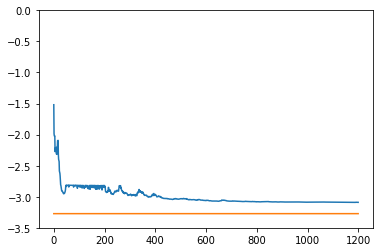

In [19]:
a = np.exp( -e[arg[0]]/T )
b = np.exp( -e[arg[1]]/T ) 
c = np.exp( -e[arg[2]]/T )
d = np.exp( -e[arg[3]]/T )
rhop = rho(a,b,c,d)


Ep = FreeE(T,H,rhop)
Epl = [Ep for k in kl]

plt.plot(kl,El)
plt.plot(kl,Epl)
plt.ylim(-3.5,0.0)

In [20]:
print( FreeE(T,H,rhop) )
print( FreeE(T,H,rhof(Sf,phif) ) )
print('dE = ', FreeE(T,H,rhop) - FreeE(T,H,rhof(Sf,phif) ) )
print('dE/E = ', (FreeE(T,H,rhop) - FreeE(T,H,rhof(Sf,phif)))/FreeE(T,H,rhop)  )

(-3.2722345306848+0j)
(-3.090121881589193+0j)
dE =  (-0.1821126490956071+0j)
dE/E =  (0.055653910924745136-0j)


In [21]:
print( S(rhop) )
print( Sf )
print( S(rhof(Sf,phif)) )

(-1.15766814+0j)
-1.2519816145591243
(-1.25198162+0j)


In [22]:
print( np.trace(Mdot([rhop,H])) )
print( np.trace(Mdot([rhof(Sf,phif),H])) )

(-0.9568982506848001+0j)
(-0.5861586415891931+0j)
